# Assigning TF Motifs to ChIP-seq peaks

This tutorial demonstrates one way to assign CTCF motifs to CTCF ChIP-seq peaks using bioframe.


In [1]:
import bioframe
import os
import subprocess
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

In [2]:
base_dir = '/tmp/bioframe_tutorial_data/'
assembly = 'GRCh38'

### Load CTCF ChIP-seq peaks for HFF from ENCODE

In [3]:
### this approach makes use of bioframe.EncodeClient
if os.path.exists(base_dir+assembly+'/ENCFF401MQL.bed.gz')==False:
    print('getting data from ENCODE, please wait while client initializes')
    client = bioframe.EncodeClient(base_dir, assembly)  
    ### note: ENCODE metadata from https://www.encodeproject.org/metadata/type=Experiment&status=released/
    ### must be in ./base_dir/
    file_path = client.fetch('ENCFF401MQL')
    ctcf_peaks = bioframe.read_table(file_path, schema='narrowPeak')
else:
    ctcf_peaks = bioframe.read_table(base_dir+assembly+'/ENCFF401MQL.bed.gz', schema='narrowPeak')
ctcf_peaks[0:5]

,chrom,start,end,name,score,strand,fc,-log10p,-log10q,relSummit
0,chr19,48309541,48309911,.,1000,.,5.04924,-1.0,0.00438,185
1,chr4,130563716,130564086,.,993,.,5.05052,-1.0,0.00432,185
2,chr1,200622507,200622877,.,591,.,5.05489,-1.0,0.00400,185
3,chr5,112848447,112848817,.,869,.,5.05841,-1.0,0.00441,185
4,chr1,145960616,145960986,.,575,.,5.05955,-1.0,0.00439,185


### get CTCF motifs from JASPAR

In [4]:
### CTCF: http://jaspar.genereg.net/matrix/MA0139.1/
ctcf_motif_file = 'MA0139.1.tsv.gz'
if  not os.path.exists(base_dir+assembly+'/'+ctcf_motif_file):
    subprocess.call('wget http://expdata.cmmt.ubc.ca/JASPAR/downloads/UCSC_tracks/2018/hg38/tsv/'+
        ctcf_motif_file+' -qO ' +base_dir+assembly+'/'+ctcf_motif_file, shell=True)
else: 
    print('already downloaded')
ctcf_motifs = bioframe.read_jaspar_tsv(base_dir+assembly+'/'+ctcf_motif_file) 

### current alternative:
###      ctcf_motifs = bioframe.read_table(base_dir+assembly+'/'+ctcf_motif_file, 
###                         schema='jaspar', skiprows=1)
### should we modify schema to accept additonal kwargs? 
### then this wouldn't require a function or passing additional arguments

ctcf_motifs[0:4]

already downloaded


,chrom,start,end,name,score,pval,strand
0,chrM,1259,1277,CTCF,825,449,-
1,chrM,9965,9983,CTCF,802,400,-
2,chr10,11428,11446,CTCF,808,455,-
3,chr10,11454,11472,CTCF,800,428,-


### overlap peaks & motifs

In [5]:
df_peaks_motifs = bioframe.overlap(ctcf_peaks,ctcf_motifs)

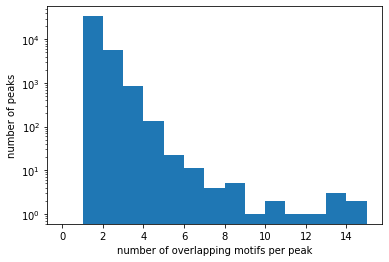

In [6]:
### there are often multiple motifs overlapping one ChIP-seq peak ###
motifs_per_peak = df_peaks_motifs.groupby(["chrom_1", "start_1","end_1"]).size().values
plt.hist(motifs_per_peak,np.arange(0,np.max(motifs_per_peak)))
plt.xlabel('number of overlapping motifs per peak')
plt.ylabel('number of peaks')
plt.semilogy();

#### assign the strongest motif to each peak

In [7]:
# since idxmax does not currently take NA, fill with -1
df_peaks_motifs['pval_2'] = df_peaks_motifs['pval_2'].fillna(-1) 
idxmax_peaks_motifs = df_peaks_motifs.groupby(["chrom_1", "start_1","end_1"])["pval_2"].idxmax().values
df_peaks_maxmotif = df_peaks_motifs.loc[idxmax_peaks_motifs]
df_peaks_maxmotif['pval_2'].replace(-1,pd.NA,inplace=True)

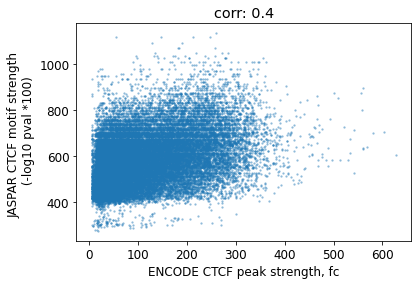

In [8]:
### stronger peaks tend to have stronger motifs ###
plt.rcParams['font.size']=12
df_peaks_maxmotif['fc_1']  = df_peaks_maxmotif['fc_1'].values.astype('float')
plt.scatter(df_peaks_maxmotif['fc_1'].values, 
            df_peaks_maxmotif['pval_2'].values, 5, alpha=0.5,lw=0)
plt.xlabel('ENCODE CTCF peak strength, fc')
plt.ylabel('JASPAR CTCF motif strength \n (-log10 pval *100)')
plt.title('corr: '+str(np.round(df_peaks_maxmotif['fc_1'].corr(df_peaks_maxmotif['pval_2']),2)));

In [9]:
### how many motifs overlap a peak? ###
df_motifs_peaks = bioframe.overlap(ctcf_motifs,ctcf_peaks,how='left')

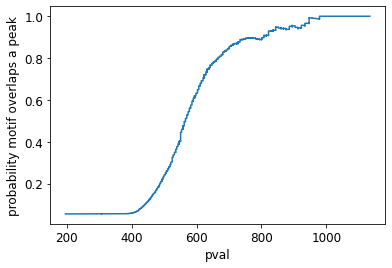

In [10]:
m = df_motifs_peaks.sort_values('pval_1')
plt.plot( m['pval_1'].values[::-1] ,
    np.cumsum(pd.isnull(m['chrom_2'].values[::-1])==0)/np.arange(1,len(m)+1))
plt.xlabel('pval')
plt.ylabel('probability motif overlaps a peak');


### filter peaks overlapping blacklisted regions

In [11]:
### do any of our peaks overlap blacklisted genomic regions? ###
encode_blacklist_file= 'ENCFF356LFX.bed.gz'
if  not os.path.exists(base_dir+assembly+'/'+encode_blacklist_file):
    subprocess.call('wget https://www.encodeproject.org/files/ENCFF356LFX/@@download/'+
            encode_blacklist_file + ' -qO ' + base_dir+assembly+'/'+encode_blacklist_file, shell=True)
blacklist = bioframe.read_table(base_dir+assembly+'/'+encode_blacklist_file,schema='bed3')
blacklist[0:3]

,chrom,start,end
0,chr1,628903,635104
1,chr1,5850087,5850571
2,chr1,8909610,8910014


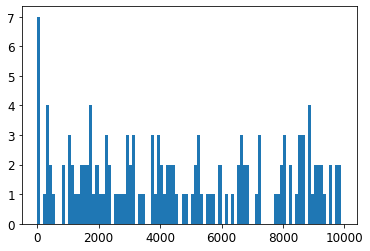

In [12]:
### there appears to be a small spike in the number of peaks close to blacklist regions
import matplotlib.pyplot as plt
closest_to_blacklist = bioframe.closest(ctcf_peaks,blacklist)
plt.hist(closest_to_blacklist['distance'],np.arange(0,1e4,100));

In [13]:
### to be safe, let'ss remove anything +/- 1kb from a blacklisted region

# first let's select the columns we want for our final dataframe of peaks with motifs
df_peaks_maxmotif = df_peaks_maxmotif[
                            ['chrom_1','start_1','end_1','fc_1',
                             'chrom_2','start_2','end_2','pval_2','strand_2']]
#  then rename columns for convenience when subtracting
for i in df_peaks_maxmotif.keys():
    if '_1' in i: df_peaks_maxmotif.rename(columns={i:i.split('_')[0]},inplace=True)

# now subtract, expanding the blacklist by 1kb        
df_peaks_maxmotif_clean = bioframe.subtract(df_peaks_maxmotif,bioframe.expand(blacklist,1000))


In [14]:
### there it is! we now have a dataframe containing positions of CTCF ChIP peaks,
### including the strongest motif underlying that peak, and after conservative
### filtering for proximity to blacklisted regions ###

df_peaks_maxmotif_clean.iloc[0:3]

,chrom,start,end,fc,chrom_2,start_2,end_2,pval_2,strand_2
0,chr1,869859,869963,86.89933,chr1,869918,869936,788.0,+
1,chr1,904744,904882,86.21221,chr1,904768,904786,957.0,+
2,chr1,921143,921277,107.85066,chr1,921192,921210,566.0,-
